In [12]:
# Half-Life as implemented by Duolingo 

In [89]:
import math
import numpy as np
from collections import defaultdict, namedtuple
from sklearn.metrics import r2_score
from sys import intern
import pandas as pd
import warnings
import os

%run diagnostics.ipynb


In [14]:
cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'POS', 'person', 
                  'number', 'gender', 'tense', 'def']

In [15]:
current_dir = os.getcwd()

filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')

dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')
dff.drop(columns=cols_to_drop, inplace=True)

In [16]:
dff.head()

,word_len,tags_list,SUBTLEX,p_recall,delta,learning_language,ui_language,history_seen,history_correct,session_seen,session_correct,h_recall,lang_combination,avg_user_p_recall,avg_delta,std_delta,avg_h_recall
0,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,5963,de,en,8,6,6,6,0.750000,en-de,0.614120,3104.416667,2977.078695,0.890225
1,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,0.0,253,de,en,14,12,1,0,0.857143,en-de,0.614120,3104.416667,2977.078695,0.890225
2,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,65,de,en,15,12,1,1,0.800000,en-de,0.614120,3104.416667,2977.078695,0.890225
3,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,0.5,27,de,en,16,13,2,1,0.812500,en-de,0.614120,3104.416667,2977.078695,0.890225
4,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,179,de,en,15,15,2,2,1.000000,en-de,0.913633,87253.516209,141166.529740,0.914070


In [17]:
# Constants
min_half_life = 15.0 / (24 * 60)  # 15 minutes in days
max_half_life = 274.0            # 9 months
LN2 = math.log(2)

# Utility functions
def pclip(p):
    """Clip recall probability to avoid numerical issues."""
    return p.clip(0.0001, 0.9999)


def hclip(h):
    """Clip half-life to a reasonable range."""
    return h.clip(min_half_life, max_half_life)

def mae(l1, l2):
    # mean average error
    return mean([abs(l1[i] - l2[i]) for i in range(len(l1))])

def mean(lst):
    # the average of a list
    return float(sum(lst))/len(lst)

In [18]:
dff.columns

Index(['word_len', 'tags_list', 'SUBTLEX', 'p_recall', 'delta',
       'learning_language', 'ui_language', 'history_seen', 'history_correct',
       'session_seen', 'session_correct', 'h_recall', 'lang_combination',
       'avg_user_p_recall', 'avg_delta', 'std_delta', 'avg_h_recall'],
      dtype='object')

In [19]:
# Changes to dataset before fitting 
dff['p_recall'] = pclip(dff['p_recall'])
dff['half_life'] = hclip(-dff['delta']/np.log2(dff['p_recall']))

dff['delta'] = dff['delta']/(60*60*24) # convert time delta to days
dff['avg_delta'] = dff['avg_delta']/(60*60*24) 
dff['std_delta'] = dff['std_delta']/(60*60*24)
dff['history_wrong'] = dff['history_seen'] - dff['history_correct']

tag_counts = dff['tags_list'].value_counts()
rare_threshold = 1000
dff['tags_list'] = dff['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')


dff_final = dff.drop(columns=['learning_language_y', 'ui_language_y', 'learning_language_x', 'ui_language_x', 'avg_user_p_recall'], errors='ignore')
dff.dropna(inplace=True)
dff_final.dropna(inplace=True)

In [20]:
Instance = namedtuple('Instance', 'p_recall delta fv half_life session_seen session_correct'.split())

def create_instances_from_dataframe(df, frac=0.5):
    instances = []
    for _, row in df.iterrows():
        fv = []
        # fv.append((intern('history_seen'), np.sqrt(1 + row['history_seen'])))
        fv.append((intern('history_correct'), np.sqrt(1 + row['history_correct'])))
        fv.append((intern('history_wrong'), np.sqrt(1 + row['history_wrong'])))
        # fv.append((intern('h_recall'), np.sqrt(1+row['h_recall'])))
        fv.append((intern('word_len'), row['word_len']))
        fv.append((intern('lang_comb:' + row['lang_combination']), 1.0))
        fv.append((intern('avg_delta'), row['avg_delta']))
        # fv.append((intern('SUBTLEX'), row['SUBTLEX']))
        fv.append((intern('std_delta'), row['std_delta']))
        fv.append((intern('avg_h_recall'), row['avg_h_recall']))
        fv.append((intern('tags_list:' + row['tags_list']), 1.0))

        instance = Instance(
            p_recall=row['p_recall'],
            delta=row['delta'],
            fv=fv,
            half_life=row['half_life'],
            session_seen = row['session_seen'],
            session_correct = row['session_correct']
        )

        instances.append(instance)
        
    splitpoint = int(0.8 * len(instances))
    return instances[:splitpoint], instances[splitpoint:]

In [52]:
from collections import defaultdict
import random
import math

class HalfLifeRegression:
    def __init__(self, learning_rate=0.001, hlwt=0.001, l2wt=5, sigma=1., initial_weights=None):
        self.weights = defaultdict(float)  # Feature weights
        self.fcounts = defaultdict(int)    # Feature counts for adaptive learning rates
        self.learning_rate = learning_rate # Base learning rate
        self.hlwt = hlwt                   # Weight for half-life loss
        self.l2wt = l2wt                   # L2 regularization weight
        self.sigma = sigma                 # Sigma value for L2 regularization
        if initial_weights is not None:
            self.weights.update(initial_weights)

    def halflife(self, inst):
        """Compute predicted half-life based on feature vector."""
        try:
            dp = sum([self.weights[k] * x_k for (k, x_k) in inst.fv])  # where inst.fv is the feature vector
            dp = np.clip(dp, -50, 50)
            with np.errstate(over='raise'):
                return hclip(np.exp2(dp))
        except:
            return max_half_life  # Return a default max value if an error occurs

    def predict(self, inst):
        """Predict recall probability and half-life."""
        h_pred = self.halflife(inst)
        p_pred = 2 ** (-inst.delta / h_pred)
        return pclip(p_pred), h_pred  

    
    def train_update(self, inst):
        """Update weights using one training instance."""
        p_pred, h_pred = self.predict(inst)

        # Compute gradients
        dlp_dw = 2 * (p_pred - inst.p_recall) * (LN2 ** 2) * p_pred * (inst.delta / h_pred)
        dlh_dw = 2 * (h_pred - inst.half_life) * LN2 * h_pred

        # Update weights
        for (k, x_k) in inst.fv:
            rate = (1. / (1 + inst.p_recall)) * self.learning_rate / math.sqrt(1 + self.fcounts[k])
            # Update for recall probability loss
            self.weights[k] -= rate * dlp_dw * x_k  
            
            # Update forh half-life loss 
            self.weights[k] -= rate * self.hlwt * dlh_dw * x_k  

            # L2 regularization
            self.weights[k] -= rate * self.l2wt * self.weights[k] / self.sigma**2  
            self.fcounts[k] += 1


    def train(self, trainset):
        random.shuffle(trainset)  # Shuffle the training set
        for inst in trainset:
            self.train_update(inst)

    def losses(self, inst):
        p_pred, h_pred = self.predict(inst)
        slp = (inst.p_recall - p_pred)**2
        slh = (inst.half_life - h_pred)**2
        return slp, slh, p_pred, h_pred

    def evaluate(self, testset):
            """Evaluate the model on a test dataset."""
            results = {'p_recall': [], 'half_life': [], 'p_recall_pred': [], 'half_life_pred': [], 'slp': [], 'slh': [], 
                      'session_seen': [], 'session_correct':[]}
            for inst in testset:
                slp, slh, p_pred, h_pred = self.losses(inst)
                results['p_recall'].append(inst.p_recall)
                results['half_life'].append(inst.half_life)
                results['p_recall_pred'].append(p_pred)
                results['half_life_pred'].append(h_pred)
                results['slp'].append(slp)
                results['slh'].append(slh)
                results['session_seen'].append(inst.session_seen)
                results['session_correct'].append(inst.session_correct)
                # results['fv'].append(inst.fv) 
                # results['delta'].append(inst.delta) 
    
    
            mae_p = mae(results['p_recall'], results['p_recall_pred'])
            mae_h = mae(results['half_life'], results['half_life_pred'])
            total_slp = sum(results['slp'])
            total_slh = sum(results['slh'])
            total_l2 = sum([x ** 2 for x in self.weights.values()])
            total_loss = total_slp + self.hlwt * total_slh + self.l2wt * total_l2
            r2val = r2_score(results['p_recall'], results['p_recall_pred'])
            print(f" MAE_P: {mae_p}, MAE_H: {mae_h}, R2: {r2val}")
            return results 

In [63]:
trainset, testset = create_instances_from_dataframe(dff.sample(frac=1))
model = HalfLifeRegression()
model.train(trainset)
results = model.evaluate(testset)

 MAE_P: 0.1120074386733443, MAE_H: 38.27499703209632, R2: -0.11070193817375751


In [64]:
results_df = pd.DataFrame.from_dict(results)

In [65]:
results_df.describe()

,p_recall,half_life,p_recall_pred,half_life_pred,slp,slh,session_seen,session_correct
count,2.501100e+06,2.501100e+06,2.501100e+06,2.501100e+06,2.501100e+06,2.501100e+06,2.501100e+06,2.501100e+06
mean,8.973760e-01,2.681686e+02,9.850384e-01,2.396047e+02,8.076065e-02,6.095226e+03,1.813927e+00,1.642579e+00
std,2.696505e-01,3.592821e+01,3.044232e-02,6.343903e+01,2.470434e-01,1.328293e+04,1.354230e+00,1.313252e+00
min,1.000000e-04,7.525750e-02,2.192148e-01,1.203452e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,9.999000e-01,2.740000e+02,9.851197e-01,2.338645e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
50%,9.999000e-01,2.740000e+02,9.976228e-01,2.740000e+02,2.192790e-05,0.000000e+00,1.000000e+00,1.000000e+00
75%,9.999000e-01,2.740000e+02,9.999000e-01,2.740000e+02,1.647581e-03,2.996253e+03,2.000000e+00,2.000000e+00
max,9.999000e-01,2.740000e+02,9.999000e-01,2.740000e+02,9.996000e-01,7.503476e+04,2.000000e+01,2.000000e+01


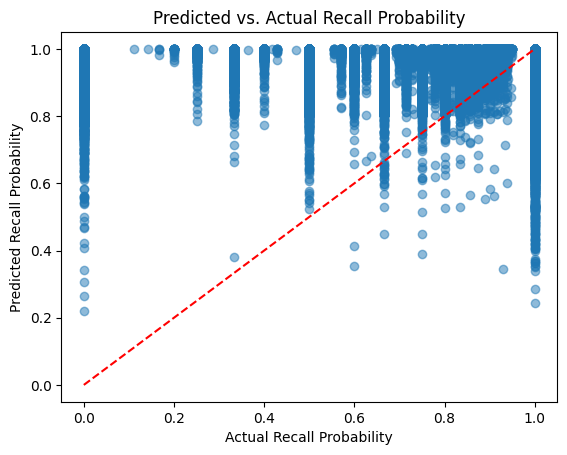

In [66]:
# Predictions vs actual recall probabilities 
def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports', filename))
    

import matplotlib.pyplot as plt
plt.scatter(results['p_recall'], results['p_recall_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
plt.savefig(out_filepath('visualizations/H_LR_predictions_scatterplot.png'))


In [67]:
expanded_df = results_df.loc[results_df.index.repeat(results_df["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(results_df["session_seen"], results_df["session_correct"])
])

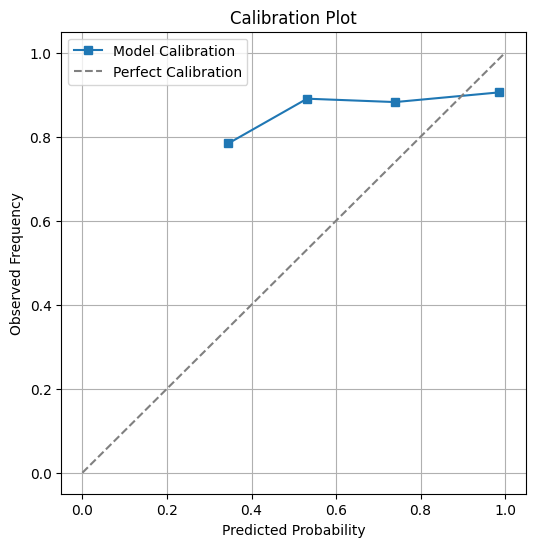

In [91]:
plot_calibration(expanded_df['outcome'], expanded_df['p_recall_pred'], 'H_LR_calibration_plot.png')


AUC Score: 0.5343


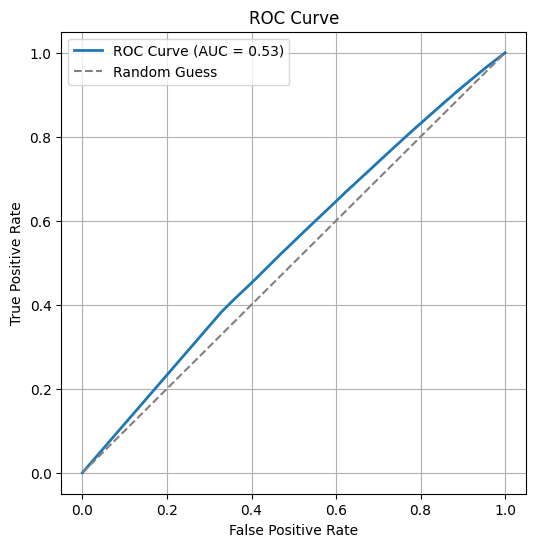

In [72]:
AUC_ROC(expanded_df['outcome'], expanded_df['p_recall_pred'], 'H_LR_ROC_plot.png')

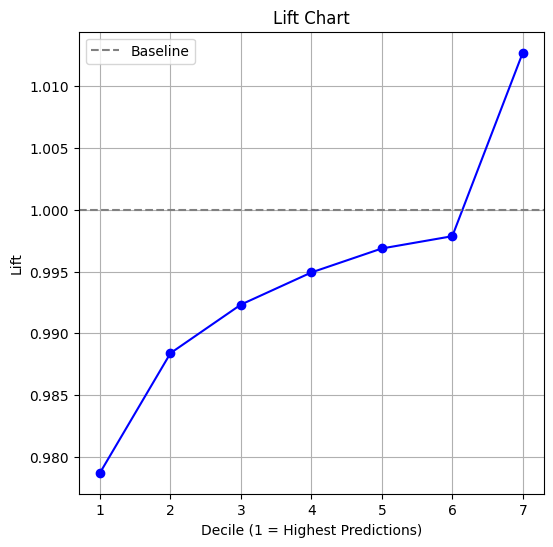

In [90]:
plot_lift(expanded_df, expanded_df['p_recall_pred'], 'H_LR_lift_plot.png')